# Generating data with the prior/posterior distribution

Visualizing the distribution of the prior can help to manually choose a better prior (being completely uninformative is just useless). Also, visualizing the posterior distribution allows to verify if the posterior is correct or completely wrong.

In [1]:
import pandas
from plotnine import *
import warnings
import pystan
import matplotlib.pyplot as plt
import numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

def generate_dataset(intercepts, coefficients, weights, N=1000, min_x=0, max_x=100, sigma=0.1):
    numpy.random.seed(42)
    coefficients = numpy.asarray(coefficients)
    intercepts = numpy.asarray(intercepts)
    nb_modes = len(intercepts)
    assert nb_modes == len(coefficients) == len(weights)

    z = numpy.random.choice(range(nb_modes), N, p=weights)
    msg_size = numpy.random.randint(min_x, max_x, N)
    duration = coefficients[z] * msg_size + intercepts[z] + numpy.random.normal(0, sigma, N)
    df = pandas.DataFrame(dict(msg_size=msg_size, duration=duration, group=z))
    return df

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def summarise(values, nb_modes):
    if len(values.shape) == 1:
        return [(values.mean(), values.std())]*nb_modes
    elif len(values.shape) == 2:
        assert values.shape[1] == nb_modes
        return [(values[:,i].mean(), values[:,i].std()) for i in range(nb_modes)]
    else:
        assert False


def get_generated_data(fit, df):
    fit = fit.extract()
    nb_modes = fit['intercept'].shape[1]
    data = []
    d_inter = summarise(fit['intercept'], nb_modes)
    d_sigma = summarise(fit['sigma'], nb_modes)
    d_coeff = summarise(fit['coefficient'], nb_modes)
    d_theta = [mean for mean, sd in summarise(fit['theta'], nb_modes)]
    for msg_size in df.msg_size:
        mode = numpy.random.choice(range(nb_modes), p=d_theta)
        data.append({'intercept': numpy.random.normal(*d_inter[mode]),
                     'coefficient': numpy.random.normal(*d_coeff[mode]),
                     'mode': mode,
                     'sigma': abs(numpy.random.normal(*d_sigma[mode])),
                     'msg_size': msg_size,
                    })
    data = pandas.DataFrame(data)
    data['duration'] = numpy.random.normal(data.msg_size * data.coefficient + data.intercept, data.sigma)
    return data

def plot_generated_data(fit, df):
    data = get_generated_data(fit, df)
    return ggplot(data, aes(x='msg_size', y='duration', color='factor(mode)')) + geom_point() + geom_point(x=df.msg_size, y=df.duration, color='black', alpha=0.3)

In [3]:
plt.rcParams["figure.figsize"] = (20,6)

### Single-mode coefficient

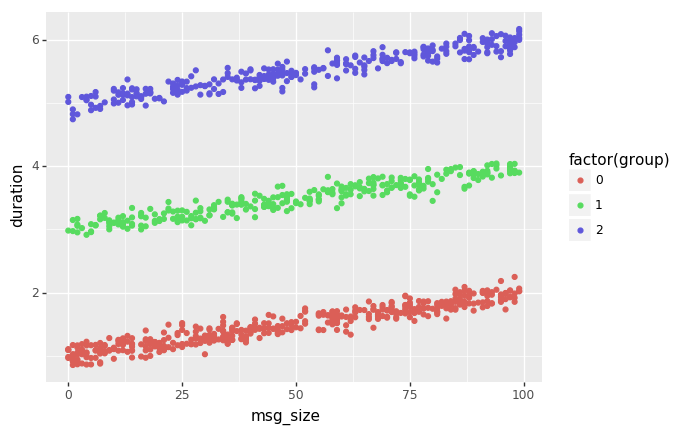

<ggplot: (8785086802552)>

In [4]:
df = generate_dataset([1, 3, 5], [0.01]*3, [0.4, 0.3, 0.3])
ggplot(df, aes(x='msg_size', y='duration', color='factor(group)')) + geom_point()

In [5]:
%%time

model_code = """
data {
    int<lower=1> N; // number of points
    real<lower=0> duration[N];
    real<lower=0> msg_size[N];
    int<lower=1> nb_modes;
    int<lower = 0, upper = 1> run_estimation; // a switch to evaluate the likelihood, see http://modernstatisticalworkflow.blogspot.com/2017/04/an-easy-way-to-simulate-fake-data-from.html
    real<lower=0> sd_intercept;
    real<lower=0> sd_coefficient;
    real<lower=0> sd_sigma;
}
parameters {
    ordered[nb_modes] intercept;
    real coefficient;
    real<lower=0> sigma[nb_modes];
    simplex[nb_modes] theta;
}
model {
    intercept[1] ~ normal(1, sd_intercept);
    intercept[2] ~ normal(3, sd_intercept);
    intercept[3] ~ normal(5, sd_intercept);
    coefficient ~ normal(0.01, sd_coefficient); 
    sigma ~ normal(0.1, sd_sigma);
    theta ~ dirichlet(rep_vector(1.0, nb_modes));
    if(run_estimation==1){
        for (i in 1:N) {
            vector[nb_modes] contributions;
            for(k in 1:nb_modes) {
                contributions[k] = log(theta[k]) + normal_lpdf(duration[i] | intercept[k] + coefficient*msg_size[i], sigma[k]);
            }
            target += log_sum_exp(contributions);
        }
    }
}
"""

sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9a2869ced419640719c4eeedce016755 NOW.


CPU times: user 778 ms, sys: 51.9 ms, total: 830 ms
Wall time: 52.3 s


Inference for Stan model: anon_model_9a2869ced419640719c4eeedce016755.
8 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=2000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
intercept[0]   0.87    0.02   0.91  -1.01   0.27   0.93    1.5   2.48   1490    1.0
intercept[1]   3.05    0.02   0.85   1.42   2.47   3.02   3.63   4.75   1513    1.0
intercept[2]   5.07    0.02   0.92   3.39   4.43   5.04   5.68   6.92   1420    1.0
coefficient  9.7e-3  2.3e-4   0.01-9.8e-3 2.7e-3 9.9e-3   0.02   0.03   2000    1.0
sigma[0]       0.13  2.0e-3   0.08 7.7e-3   0.07   0.12   0.18    0.3   1480    1.0
sigma[1]       0.13  1.8e-3   0.08 6.2e-3   0.07   0.12   0.18    0.3   2000    1.0
sigma[2]       0.13  2.5e-3   0.08 6.7e-3   0.06   0.11   0.18   0.29   1045    1.0
theta[0]       0.33  5.2e-3   0.23   0.01   0.14    0.3   0.49   0.84   2000    1.0
theta[1]       0.33  5.2e-3   0.23   0.01   0.13   0.28   

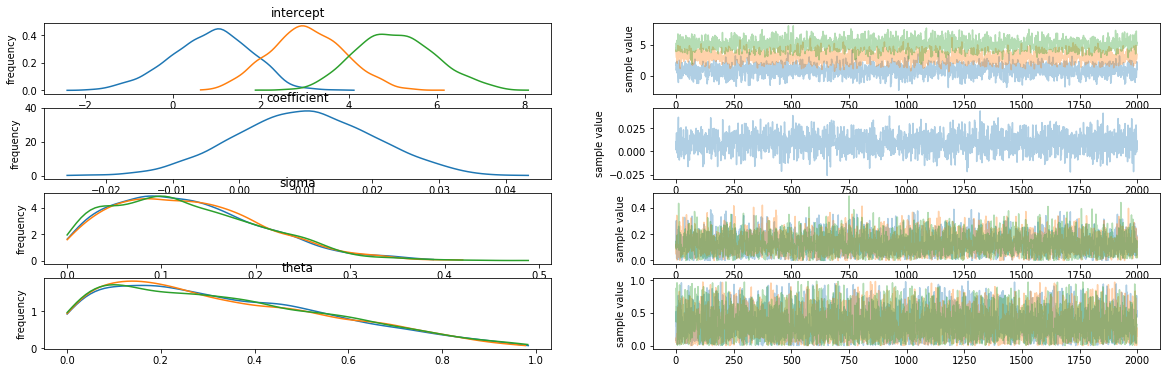

In [6]:
%%time

def initfunction():
    return {
        'intercept': [1, 3, 5],
        'coefficient': 0.01,
        'sigma': [0.1]*3,
    }

data=dict(N=len(df), duration=df.duration, msg_size=df.msg_size, nb_modes=3, run_estimation=0,
                            sd_intercept=1, sd_coefficient=0.01, sd_sigma=0.1)
fit = sm.sampling(data=data, iter=500, chains=8, init=initfunction)

print(fit)

fit.plot()

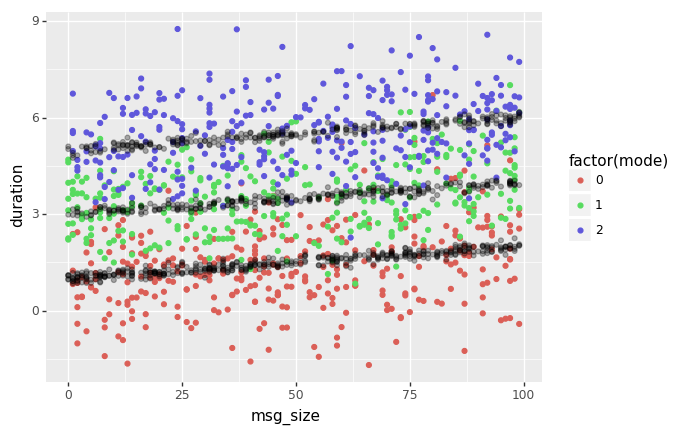

<ggplot: (8785077716239)>

In [7]:
plot_generated_data(fit, df)

Inference for Stan model: anon_model_9a2869ced419640719c4eeedce016755.
8 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=2000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
intercept[0]    1.0  1.6e-4 7.0e-3   0.99    1.0    1.0    1.0   1.01   2000    1.0
intercept[1]   2.99  1.7e-4 7.7e-3   2.97   2.98   2.99    3.0    3.0   2000    1.0
intercept[2]   4.99  1.8e-4 8.1e-3   4.98   4.99   4.99    5.0   5.01   2000    1.0
coefficient    0.01  2.5e-6 1.1e-4 9.8e-310.0e-3   0.01   0.01   0.01   2000    nan
sigma[0]        0.1  8.4e-5 3.5e-3   0.09    0.1    0.1    0.1   0.11   1721    1.0
sigma[1]       0.09  1.0e-4 4.0e-3   0.09   0.09   0.09    0.1    0.1   1524    1.0
sigma[2]        0.1  1.1e-4 4.3e-3   0.09    0.1    0.1    0.1   0.11   1544    1.0
theta[0]       0.42  4.1e-4   0.02   0.39   0.41   0.42   0.43   0.45   1565    1.0
theta[1]       0.29  4.0e-4   0.01   0.26   0.28   0.29   

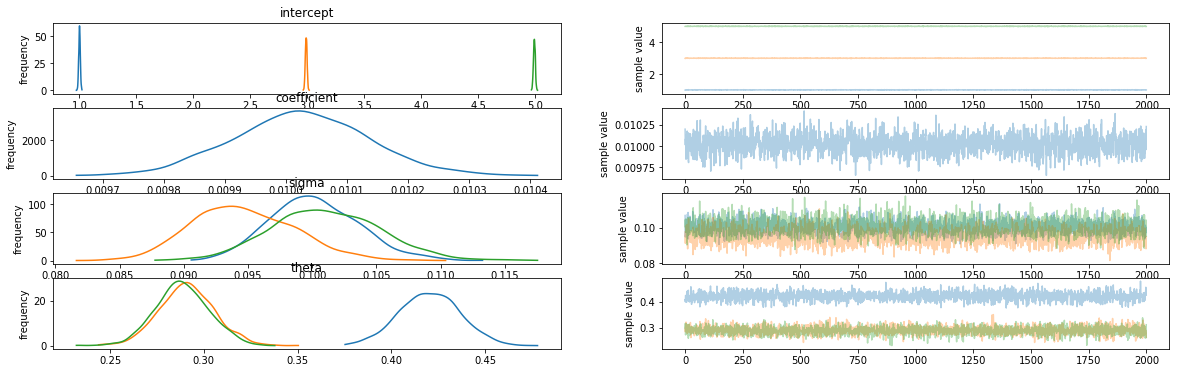

In [8]:
%%time

data['run_estimation'] = 1
fit = sm.sampling(data=data, iter=500, chains=8, init=initfunction)

print(fit)

fit.plot()

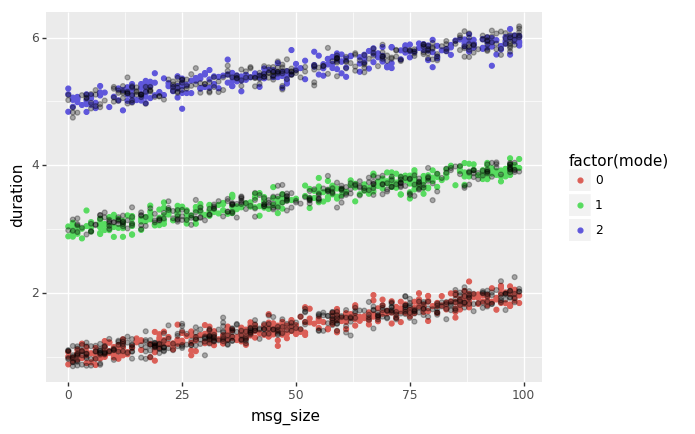

<ggplot: (-9223363251767949985)>

In [9]:
plot_generated_data(fit, df)

### Trimodal coefficient, trimodal intercept

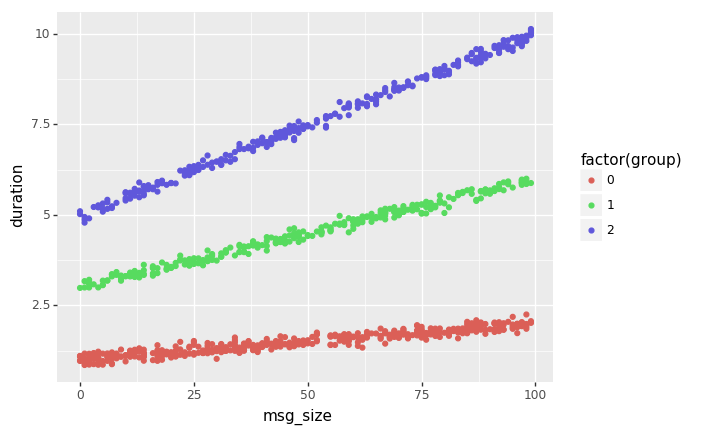

<ggplot: (8785077605878)>

In [10]:
df = generate_dataset([1, 3, 5], [0.01, 0.03, 0.05], [0.4, 0.3, 0.3])
ggplot(df, aes(x='msg_size', y='duration', color='factor(group)')) + geom_point()

In [11]:
%%time

model_code = """
data {
    int<lower=1> N; // number of points
    real<lower=0> duration[N];
    real<lower=0> msg_size[N];
    int<lower=1> nb_modes;
    int<lower = 0, upper = 1> run_estimation; // a switch to evaluate the likelihood, see http://modernstatisticalworkflow.blogspot.com/2017/04/an-easy-way-to-simulate-fake-data-from.html
    real<lower=0> sd_intercept;
    real<lower=0> sd_coefficient;
    real<lower=0> sd_sigma;
}
parameters {
    ordered[nb_modes] intercept;
    ordered[nb_modes] coefficient;
    real<lower=0> sigma[nb_modes];
    simplex[nb_modes] theta;
}
model {
    intercept[1] ~ normal(1, sd_intercept);
    intercept[2] ~ normal(3, sd_intercept);
    intercept[3] ~ normal(5, sd_intercept);
    coefficient[1] ~ normal(0.01, sd_coefficient);
    coefficient[2] ~ normal(0.03, sd_coefficient);
    coefficient[3] ~ normal(0.05, sd_coefficient);
    sigma ~ normal(0.1, sd_sigma);
    theta ~ dirichlet(rep_vector(1.0, nb_modes));
    if(run_estimation==1) {
        for (i in 1:N) {
            vector[nb_modes] contributions;
            for(k in 1:nb_modes) {
                contributions[k] = log(theta[k]) + normal_lpdf(duration[i] | intercept[k] + coefficient[k]*msg_size[i], sigma[k]);
            }
            target += log_sum_exp(contributions);
        }
    }
}
"""

sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e70d2c271431c85177cc0499201cf2a5 NOW.


CPU times: user 778 ms, sys: 65.1 ms, total: 843 ms
Wall time: 47.4 s


Inference for Stan model: anon_model_e70d2c271431c85177cc0499201cf2a5.
8 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=2000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
intercept[0]     0.81    0.02   0.93  -1.08   0.19   0.81   1.45   2.59   1414    1.0
intercept[1]     3.03    0.02   0.85   1.28   2.46   3.05   3.59   4.72   1813    1.0
intercept[2]     5.13    0.02   0.89   3.39   4.51   5.14   5.72   6.91   2000    1.0
coefficient[0] 8.8e-3  2.2e-4 9.7e-3-9.5e-3 2.3e-3 8.9e-3   0.02   0.03   2000    1.0
coefficient[1]   0.03  2.2e-4 8.4e-3   0.01   0.02   0.03   0.04   0.05   1464    1.0
coefficient[2]   0.05  2.5e-4 9.2e-3   0.03   0.05   0.05   0.06   0.07   1340    1.0
sigma[0]         0.13  2.3e-3   0.08 9.0e-3   0.07   0.12   0.19   0.31   1187    1.0
sigma[1]         0.13  2.0e-3   0.08 7.2e-3   0.06   0.12   0.18    0.3   1615    1.0
sigma[2]         0.13  2.8e-3   0.08 4.9

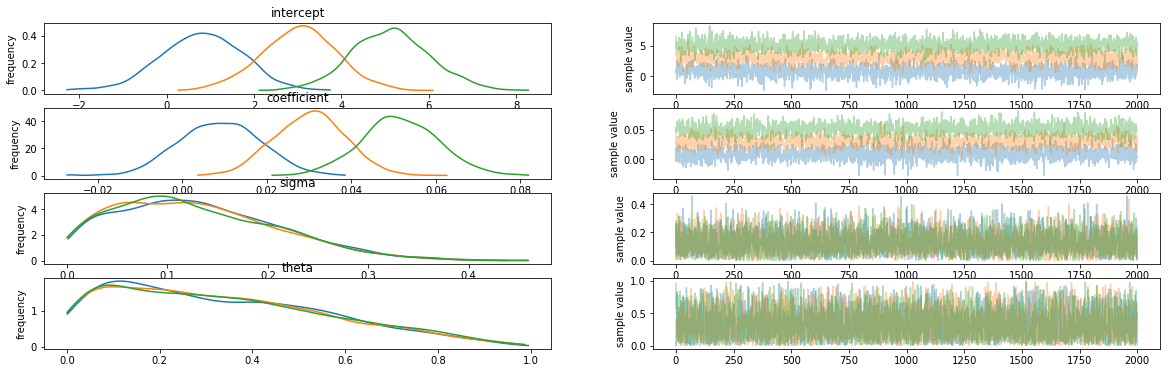

In [12]:
%%time

def initfunction():
    return {
        'intercept': [1, 3, 5],
        'coefficient': [0.01, 0.03, 0.05],
        'sigma': [0.1]*3,
    }

data=dict(N=len(df), duration=df.duration, msg_size=df.msg_size, nb_modes=3, run_estimation=0,
                            sd_intercept=1, sd_coefficient=0.01, sd_sigma=0.1)

fit = sm.sampling(data=data, iter=500, chains=8, init=initfunction)
print(fit)

fit.plot()

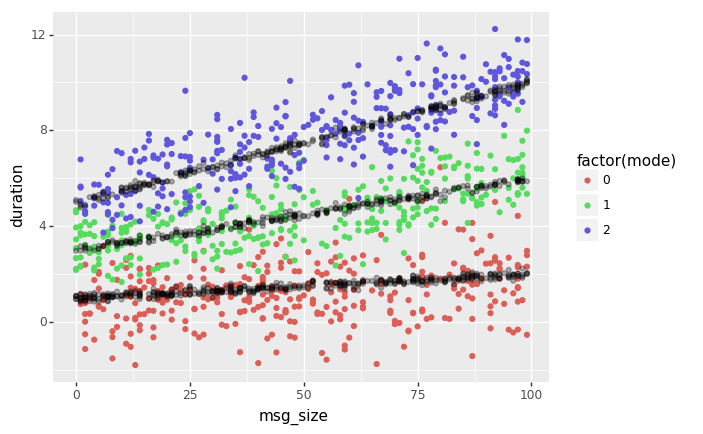

<ggplot: (-9223363251735280871)>

In [13]:
plot_generated_data(fit, df)

Inference for Stan model: anon_model_e70d2c271431c85177cc0499201cf2a5.
8 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=2000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
intercept[0]      1.0  2.1e-4 9.3e-3   0.98    1.0    1.0   1.01   1.02   1913    1.0
intercept[1]      3.0  3.1e-4   0.01   2.98    3.0    3.0   3.01   3.03   1411    1.0
intercept[2]     4.98  2.6e-4   0.01   4.95   4.97   4.98   4.98    5.0   2000    1.0
coefficient[0]10.0e-3  3.8e-6 1.6e-4 9.7e-3 9.9e-310.0e-3   0.01   0.01   1833    nan
coefficient[1]   0.03  5.5e-6 2.1e-4   0.03   0.03   0.03   0.03   0.03   1437    nan
coefficient[2]   0.05  4.6e-6 2.0e-4   0.05   0.05   0.05   0.05   0.05   2000    nan
sigma[0]          0.1  7.6e-5 3.4e-3   0.09    0.1    0.1    0.1   0.11   2000    1.0
sigma[1]         0.09  8.9e-5 4.0e-3   0.09   0.09   0.09    0.1    0.1   2000    1.0
sigma[2]          0.1 10.0e-5 4.3e-3   0

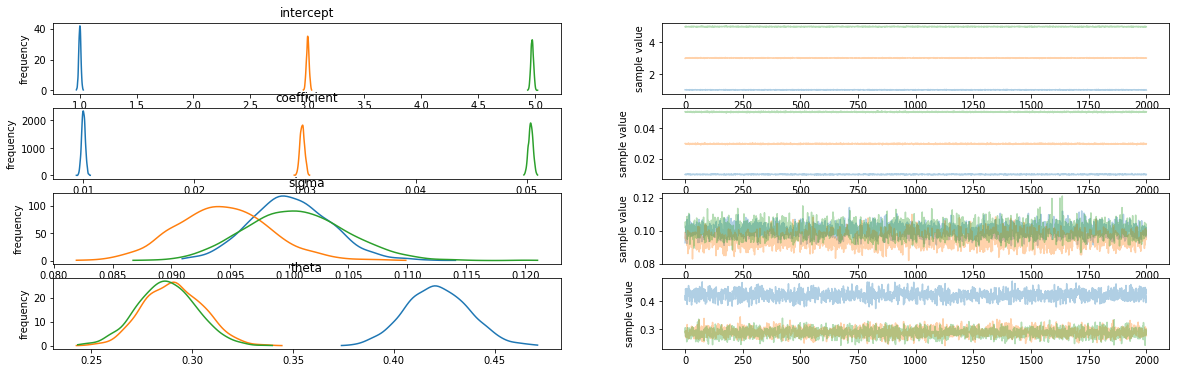

In [14]:
%%time

data['run_estimation'] = 1
fit = sm.sampling(data=data, iter=500, chains=8, init=initfunction)
print(fit)

fit.plot()

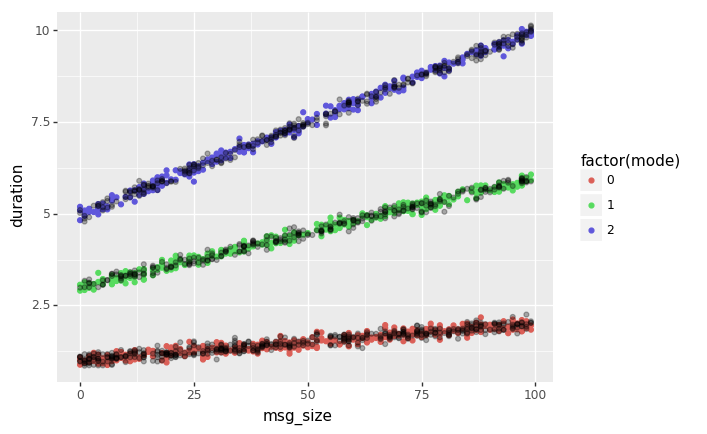

<ggplot: (-9223363251703936803)>

In [15]:
plot_generated_data(fit, df)